#Computer Vision Fall 2022 - HW-1, Question-2
@author: Shri Ramya Ashok
#2) Homograph Estimation
First compute SIFT and SIFT matches, then select good matches to solve homography as an over-determined linear equation via SVD. Show your code and solution details, as well as the final homography matrix. Use matlab imtransform to wrap the image according to the homography and verify the accuracy.  

##A) How many SIFT points pairs you found ? Select the best M=8 matching pairs, and use that to compute your Matrix A, for Ah=0 homography solution

###Step 1:Compute SIFT matches

Read both the images and find SIFTs of each image

In [ ]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('sift-1.jpg')  #query image
img2 = cv2.imread('sift-2.jpg')  #train image

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

###Step 2: Find SIFT matches of boht the images

Brute Force matcher is used to computer SIFT matches. All the matches are projected in the image below.

Matching SIFT projections:



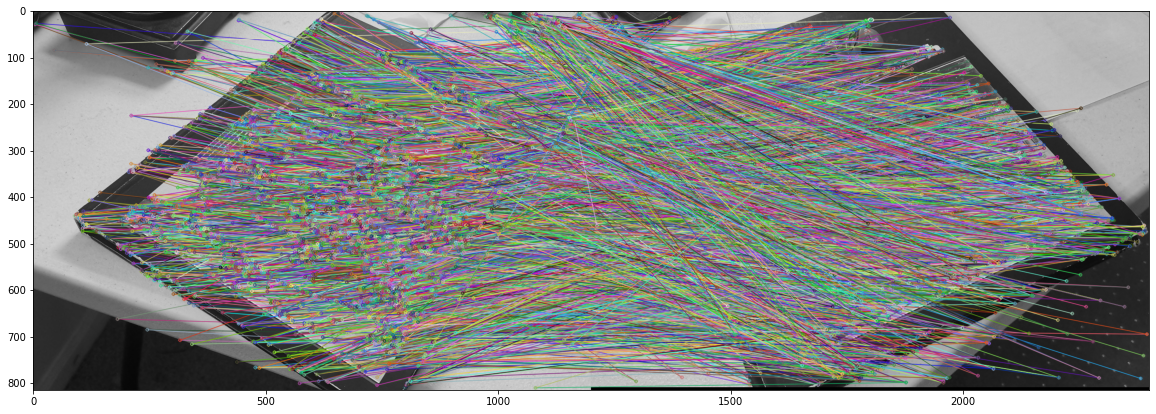

In [ ]:
#feature matching
bf = cv2.BFMatcher()

matches = bf.knnMatch(descriptors_1,descriptors_2, 2)

#Plot the matches
img3 = cv2.drawMatchesKnn(img1,keypoints_1,img2,keypoints_2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print("Matching SIFT projections:\n")
plt.figure(figsize=(20,20))
plt.imshow(img3)

###Total number of matching pairs found is 4326 using Brute Force matcher

In [ ]:
#Total number of matches
print("Total number matches found is: ", len(matches))

Total number matches found is:  4326


###Step 3: Selct best M=8 matches using D.Lowe ratio test

D.Lowe Ratio test: Each keypoint of the first image is matched with a number of keypoints from the second image. We keep the 2 best matches for each keypoint (best matches = the ones with the smallest distance measurement). Lowe's test checks that the two distances are sufficiently different. If they are not, then the keypoint is eliminated and will not be used for further calculations.

In [ ]:
# Apply D Lowe ratio test and extract best 8 matches
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

best_eight = good[:8]

###Step 4: Visual representation of 8 best matching pairs

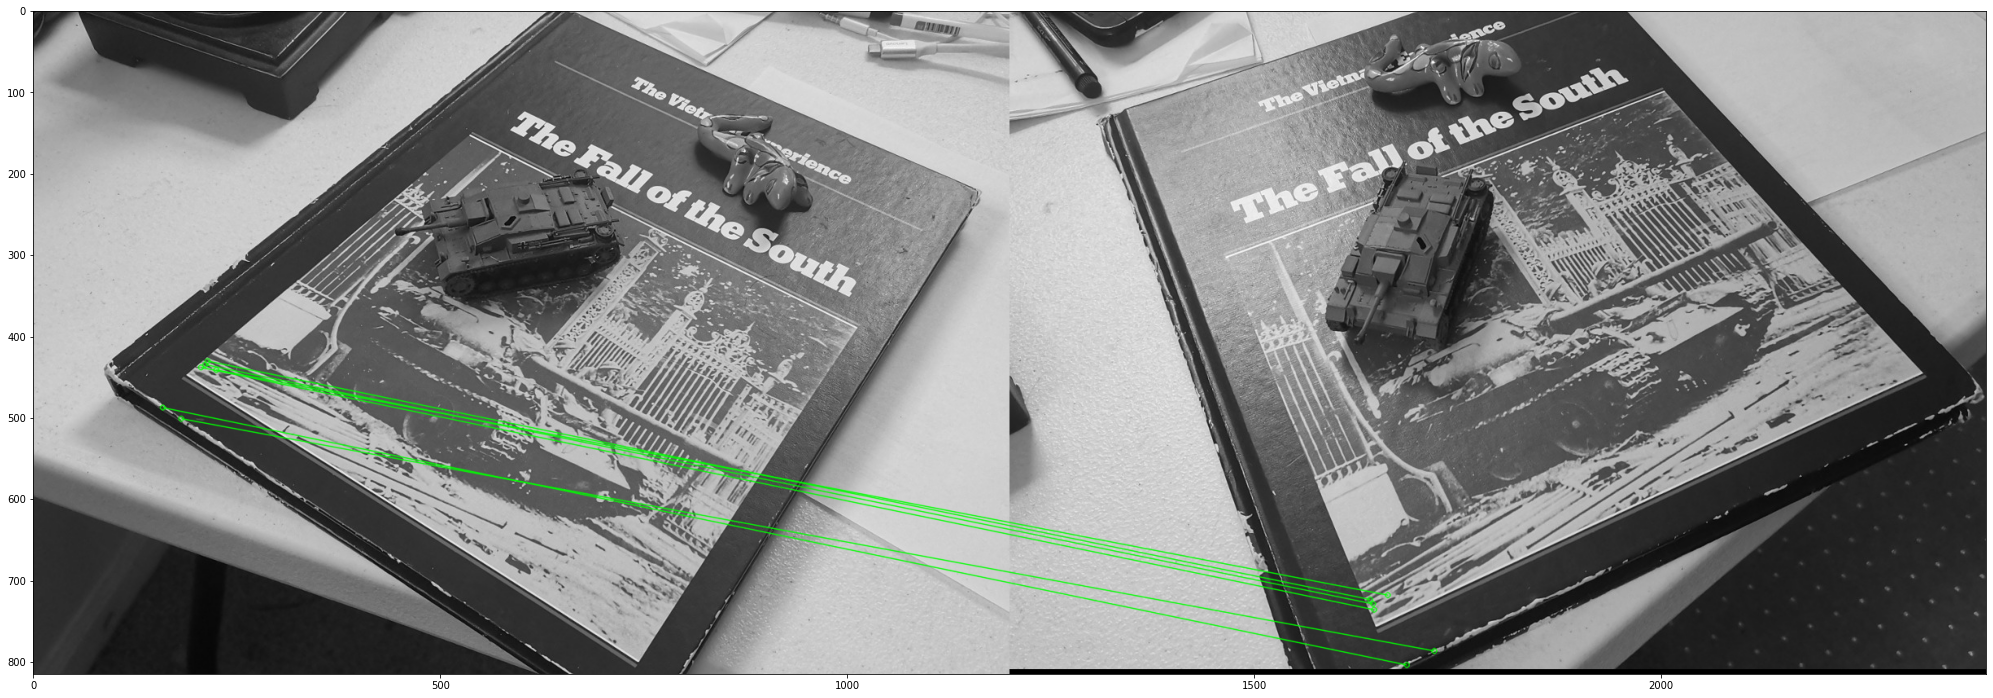

In [ ]:
import numpy as np

#Extract the planar points fromt he matches object
src_pts = np.float32([ keypoints_1[m.queryIdx].pt for m in best_eight]).reshape(-1,1,2)
dst_pts = np.float32([ keypoints_2[m.trainIdx].pt for m in best_eight]).reshape(-1,1,2)

#Find homography
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
matchesMask = mask.ravel().tolist()

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

# Draw best matching points
img3 = cv2.drawMatches(img1,keypoints_1,img2,keypoints_2,best_eight,None,**draw_params)
plt.figure(figsize=(35,35))
plt.imshow(img3)


###Step 5: Find A using 4 matching pairs.

A matrix is manually computed using 4 matching points.

In [ ]:
#Extract best 4 matching points
best_four = best_eight[:4]
#Extract coordinates of matching points
src_pts = np.float32([ keypoints_1[m.queryIdx].pt for m in best_four]).reshape(-1,1,2)
dst_pts = np.float32([ keypoints_2[m.trainIdx].pt for m in best_four]).reshape(-1,1,2)

#initialize A matrix
A=[]
for p1, p2 in zip(src_pts, dst_pts):
  #A matrix values
    a1 = p1[0][0]*p2[0][0]
    a2 = p1[0][1]*p2[0][0]
    a3 = p1[0][0]*p2[0][1]
    a4 = p1[0][1]*p2[0][1]
    row = [-p1[0][0], -p1[0][1], -1, 0 ,0 ,0, a1, a2, p2[0][0]]
    A = np.append(A, row, axis=0)
    row = [0, 0, 0, -p1[0][0], -p1[0][1], -1, a3, a4, p2[0][1]]
    A = np.append(A, row, axis=0)
    
#reshape the A matrix into 2n*9. here n=4 points. Sp shape is 8*9
A = A.reshape(8, 9)
print("The matrix A is:\n")
A

The matrix A is:



array([[-1.43945129e+02, -3.89802582e+02, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         6.74227812e+04,  1.82580500e+05,  4.68392242e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.43945129e+02, -3.89802582e+02, -1.00000000e+00,
         8.35699141e+04,  2.26306859e+05,  5.80567871e+02],
       [-1.58995758e+02, -4.87490112e+02, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         7.75539766e+04,  2.37784938e+05,  4.87773865e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.58995758e+02, -4.87490112e+02, -1.00000000e+00,
         1.27747164e+05,  3.91680125e+05,  8.03462708e+02],
       [-1.81690506e+02, -5.01113586e+02, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         9.47666797e+04,  2.61372328e+05,  5.21583008e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.81690506e+02, -5.01113586e+02, -1.000000

##B) Show the SVD of A and what are the zero singular values?

###Step 1: SVD of A is calculated using svd() function.

In [ ]:
from scipy.linalg import svd
#SVD of A matrix
U, s, VT = svd(A)
print("SVD of A matrix is\n")
print("U = ", U)
print("\ns = ", s)
print("\nVT = ", VT)

SVD of A matrix is

U =  [[ 0.2242101   0.02851478  0.35670985  0.44636228  0.40963407 -0.54517742
   0.33937469  0.20552828]
 [ 0.27790645  0.03534015 -0.23262828  0.7819061  -0.25612588  0.37670833
   0.07026547 -0.20875621]
 [ 0.28784413  0.27701061  0.43757569 -0.00587671  0.22472557  0.51078543
  -0.38162383  0.43802258]
 [ 0.47413775  0.45628949 -0.29016026 -0.08084875 -0.06113029 -0.45245719
  -0.48655222 -0.17628474]
 [ 0.32025632  0.08180928  0.45648252 -0.25521225  0.06469261  0.16412206
   0.25923129 -0.72035512]
 [ 0.48274437  0.12331284 -0.29992671 -0.3334527  -0.18317247  0.11457672
   0.59850098  0.38173509]
 [ 0.24885678 -0.43209907  0.41690625 -0.00737737 -0.68908421 -0.22130174
  -0.17341777  0.15365614]
 [ 0.40902451 -0.71020742 -0.26614577 -0.08021279  0.44697498  0.07883415
  -0.20503601 -0.05473109]]

s =  [8.68065110e+05 4.00156678e+04 9.75768714e+02 1.58965844e+02
 4.74802141e+01 4.02411808e+01 9.27751291e-01 9.64370338e-02]

VT =  [[-2.15992760e-04 -5.72828086e

###Step 2: The Zero singular values are the diagonal elements of s matrix. Actually the diagonal elements are the only non-zero elements in s matrix.

In [ ]:
print("\nThe zero singular values are:\n", s)


The zero singular values are:
 [8.68065110e+05 4.00156678e+04 9.75768714e+02 1.58965844e+02
 4.74802141e+01 4.02411808e+01 9.27751291e-01 9.64370338e-02]


#C) Show the null space solution to Ah=0, i.e,non-zero h that makes Ah=0 

Ah~0 as seen below

In [ ]:
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
#Ah
print(np.dot(A, np.reshape(M, 9)), "is almost zero as expected")

#Null space solution
print("\nThe null space solution to Ah=0 is:\n", H)

[ 1.44501809e+02 -2.15431384e+02  2.77049677e-02 -3.09741121e-02
  4.85378162e-02 -5.12402730e-02 -4.76476064e-01  5.90181208e-01] is almost zero as expected

The null space solution to Ah=0 is:
 [[ 3.03303207e+00 -2.20895281e+00  4.92191311e+02]
 [ 5.24134521e+00 -3.39372743e+00  6.52363348e+02]
 [ 6.66784340e-03 -4.65674469e-03  1.00000000e+00]]


## D) For all matched SIFT points, how many are in agreement with this homography?

We have 4326 matching pairs all together before extracting only the best ones. Lets query all these points.

###Step 1: Get Coordinates of all the matching points

###Step 2: If p1, p2 are the two points from image 1 and image 2 respectively, compute H*p1. The resultant product will be p22. Divide each element of p22 (p22 = [x22*z2, y22*z2, z2]) by z2 to get p2.
Source: https://towardsdatascience.com/estimating-a-homography-matrix-522c70ec4b2c

###Step3: Compare actual p2 and computed p2 matrices. If both of them are equal, the point pair is in agreement with our homography solution. 

Now, the matching points depends on threhold value in allclose function. 
##Case 1: Threshold: 0 - Matching points: 0
##Case 2: Threshold: 0.1 - Matching points: 89
##Case 1: Threshold: 0.5 - Matching points: 1243
##Case 1: Threshold: 1 - Matching points: 3705 
## out of 4326 matching points

In [ ]:
matches_coordinates = []
for m,n in matches:
        matches_coordinates.append(m)

#extract coordinates of all matching points
src_pts = np.float32([ keypoints_1[m.queryIdx].pt for m in matches_coordinates]).reshape(-1,1,2)
dst_pts = np.float32([ keypoints_2[m.trainIdx].pt for m in matches_coordinates]).reshape(-1,1,2)

#Function to find SIFT points that agree with out homography
def find_matching(threshold):
  agreement_number = 0
  for p1, p2 in zip(src_pts, dst_pts):
    #Actual P1
    X1 = np.array([p1[0][0], p1[0][1], 1])
    #Actual P2
    X2 = np.array([p2[0][0], p2[0][1], 1])
    #H*P1
    X2_computed= np.dot(H, X1)
    #P22/z2
    divide = X2_computed[2]
    X2_computed = X2_computed/divide
    if np.allclose(X2, X2_computed, rtol=threshold, atol=threshold):
      agreement_number+=1
  print("Matching Threshold: ", threshold, "Number of SIFT points in agreement with homography: ", agreement_number)

##Case 1: Threshold: 0 
find_matching(0)
##Case 2: Threshold: 0.1
find_matching(0.1)
##Case 1: Threshold: 0.5 
find_matching(0.5)
##Case 1: Threshold: 1
find_matching(1)

Matching Threshold:  0 Number of SIFT points in agreement with homography:  0
Matching Threshold:  0.1 Number of SIFT points in agreement with homography:  89
Matching Threshold:  0.5 Number of SIFT points in agreement with homography:  1243
Matching Threshold:  1 Number of SIFT points in agreement with homography:  3705
